Calcul de l'empreinte carbone du secteur de l'énergie solaire (photovoltaïque).

In [5]:
import pymrio as mr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle

doi = '10.5281/zenodo.5589597'
EXIOBASE_PATH = '/Users/martin/Documents/travail/miniprojet/EXIOBASE/'
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

io = mr.parse_exiobase3(path=filename)

population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

io.calc_all()

/opt/miniconda3/lib/python3.12/site-packages/pymrio/core/mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
/opt/miniconda3/lib/python3.12/site-packages/pymrio/core/mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum()
/opt/miniconda3/lib/python3.12/site-packages/pymrio/core/mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
/opt/miniconda3/lib/python3.12/site-packages/pymrio/core/mriosystem.py:956: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  F_Y_agg = self.F_Y.groupby(level="region", axis=1, sort=False).sum(

Calcul de la production photovoltaïque française.

In [3]:
io.x.loc['FR','Production of electricity by solar photovoltaic']

indout    35.435103
Name: (FR, Production of electricity by solar photovoltaic), dtype: float64

35,4M € ont été produits par le solaire en 2019.

In [8]:
purchases = io.Z['FR','Production of electricity by solar photovoltaic'].sort_values(ascending=False)
purchases.head()

region  sector                                                                                             
FR      Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                    14.235806
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)    10.117219
        Sea and coastal water transport                                                                         0.394177
        Transport via pipelines                                                                                 0.371194
        Retail sale of automotive fuel                                                                          0.291439
Name: (FR, Production of electricity by solar photovoltaic), dtype: float64

In [ ]:
purchases.sum()

29.47355737463697

Le secteur achète 29.47 M€ d'équipements/services (wholesale = vente de gros = producteurs, et retail = vente de détail = particuliers). Majorité provenant du commerce.

In [ ]:
index = ((slice(None),'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'),
         ('FR','Production of electricity by solar photovoltaic'))

In [ ]:
direct = io.A.loc[index].sort_values(ascending=False).head()
direct_indirect = io.L.loc[index].sort_values(ascending=False).head()
indirect = (direct_indirect - direct)

<Axes: xlabel='region'>

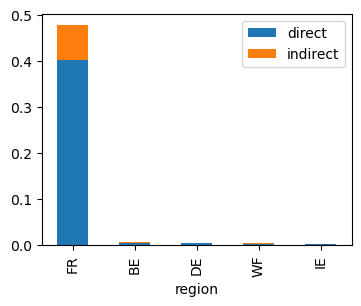

In [ ]:
pd.concat([direct,indirect],axis=1,keys=('direct','indirect')).sort_values(by='direct',ascending=False).head().droplevel(1).plot(kind='bar',stacked=True,figsize=(4,3))

Parmi les dépenses principales du secteur, on a l'achat de gros. La production solaire achète principalement en France, avec 0,40€ de dépenses directes par euro produit mais aussi 0,60€ de dépenses indirectes versées aux grossistes. 

Voir http://www.energies-renouvelables.org/observ-er/etudes/Observ-ER-Etude-2019-marche-photovoltaique-2018-20201127.pdf pour les prix moyens d'installation en 2019.

La puissance du parc solaire photovoltaïque atteint 9,9 GW, fin décembre 2019. https://www.statistiques.developpement-durable.gouv.fr/tableau-de-bord-solaire-photovoltaique-quatrieme-trimestre-2019

In [13]:
impact = io.satellite.F['FR','Production of electricity by solar photovoltaic'].head(30)
impact # Impact/émissions directs de la production de photov. en France sur l'année.

# impact = io.satellite.S['FR','Production of electricity by solar photovoltaic'].head(30) Par million d'euros.

stressor
Taxes less subsidies on products purchased: Total                                                2.688425e-02
Other net taxes on production                                                                    1.723229e-03
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled       1.156455e-04
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1.691970e-03
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      3.599038e-03
Operating surplus: Consumption of fixed capital                                                  5.893079e+00
Operating surplus: Rents on land                                                                 0.000000e+00
Operating surplus: Royalties on resources                                                        0.000000e+00
Operating surplus: Remaining net operating surplus                                               3.445237e-02
E

Regarder la table et se demander ce qu'on pourrait gagner à ramener la production de panneaux photovoltaïques en France.

Matrice Z: tout ce qui est produit et consommé sur une année
Matrice F : tout ce qui est consommé à partir d'autre chose que l'économie annuelle. Approvisionnement à partir de ressources, provient du bâti (eg. gross fixed capital) et masse salariale.

In [11]:
impact2 = io.satellite.D_cba['FR','Production of electricity by solar photovoltaic'].head(30) # consumption-based account
impact2 # Émissions sur le cylce de vie de la production totale de photovoltaïque en France de ce qui est installé en 2019.

stressor
Taxes less subsidies on products purchased: Total                                                6.836523e-03
Other net taxes on production                                                                    1.943110e-03
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled       2.887755e-03
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    1.860910e-02
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      1.096635e-02
Operating surplus: Consumption of fixed capital                                                  2.357188e-01
Operating surplus: Rents on land                                                                 0.000000e+00
Operating surplus: Royalties on resources                                                        0.000000e+00
Operating surplus: Remaining net operating surplus                                               2.507674e-02
E